In [1]:
"""
A simple example of how to train a predictive time-series model with CRBM

Created by Omid Alemi
"""

%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image
from IPython import display
from datetime import datetime
import time

import numpy as np
import tensorflow as tf
# from tensorflow.python.client import timeline

import sys
sys.path.append('../')

from xrbm.models.crbm import CRBM
from xrbm.utils.vizutils import tile_raster_images

In [27]:
 # Set up the parameters
snapshot_dir = './logs/'
snapshot_freq = 0
num_vis = 4
num_hid = 300
timesteps = 20
batch_size=100
cd_k=1
wdecay=0#0.001
activation=tf.nn.sigmoid
initializer=tf.contrib.layers.xavier_initializer()
#initializer=tf.contrib.layers.variance_scaling_initializer()
vis_type='gaussian'
regularizer = tf.contrib.layers.l1_regularizer(0.001)

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [28]:
# Create some toy sequences with sin waves

FREQS = [30, 40, 50, 60]
AMPS = [3, 1, 0.4, 1.5]
NSAMPLE = 100
SEQ_LEN = 2000

time_data = np.arange(SEQ_LEN) / 50

X_data = []

print('Making dummy time series...')
for i in range(NSAMPLE):
    x = np.asarray([np.float32(np.sin(FREQS[d] * time_data + np.random.rand()) * (AMPS[d]+np.random.rand()/20)) for d in range(num_vis)]).T
    x = np.asarray([d + np.random.rand()/20 for d in x])
    X_data.append(x)

X_data = np.asarray(X_data)

X_train = X_data[0:80]
X_test = X_data[80:]

X_train_flat = np.concatenate([m for m in X_train], axis=0)
data_mean = np.mean(X_train_flat, axis=0)
data_std = np.std(X_train_flat, axis=0)

X_train_normalized = [(d - data_mean) / data_std for d in X_train]
X_test_normalized = [(d - data_mean) / data_std for d in X_test]


def makeSeqHistory(seqs, order, step=1):
    history = []
    outputs = []
    for m in seqs:
        for i in range(0, len(m)-order, step):
            history.append(m[i:i+order].flatten())
            outputs.append(m[i+order])

    return np.asarray(history), np.asarray(outputs)


# cond_data, visible_data = makeSeqHistory(X_data, timesteps)
cond_data, visible_data = makeSeqHistory(X_train_normalized, timesteps)
test_cond, test_data = makeSeqHistory(X_test_normalized, timesteps)

num_cond = cond_data[0].shape[0]
print('Done!')

Making dummy time series...
Done!


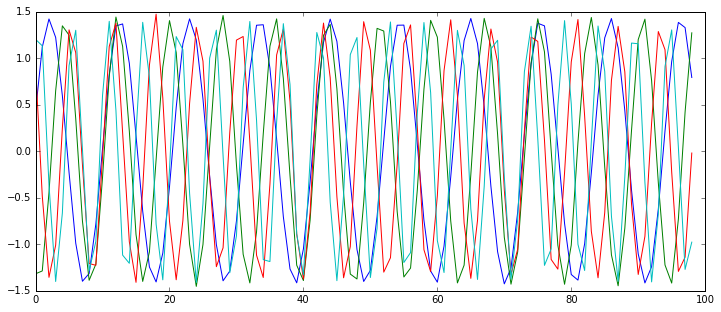

In [29]:
_=plt.figure(figsize=(12,5))
_=plt.plot(visible_data[1:100,:])

In [30]:
#_=plt.figure(figsize=(12,5))
#_=plt.plot(np.asarray(X_data_normalized)[1:10,:,0])

In [31]:
def generate():
    gen_sample = []
    gen_hidden = []
    initcond = []

    gen_init_frame = 100
    num_gen = 200

    gen_cond = tf.placeholder(tf.float32, shape=[1, cond_data.shape[1]], name='gen_cond_data')
    gen_init = tf.placeholder(tf.float32, shape=[1, visible_data.shape[1]], name='gen_init_data')
    gen_op = c1.make_prediction(gen_cond, gen_init, 60)


    for f in range(timesteps):
        gen_sample.append(np.reshape(visible_data[gen_init_frame+f], [1, num_vis]))

    # gen_cond = deque(test_cond[gen_init_frame])
    # gen_init = test_input[gen_init_frame-1] + 0.01 * np.random.randn(1, num_vis)

    print('Generating %d frames: '%(num_gen))

    for f in range(num_gen):
        initcond = np.asarray([gen_sample[s] for s in range(f,f+timesteps)]).ravel()
        # initcond = np.asarray([test_input[s+gen_init_frame] for s in range(f,f+timesteps)]).ravel()

        initframes = gen_sample[f+timesteps-1] # + 0.01 * np.random.randn(1, num_vis)

        s, h = sess.run(gen_op, feed_dict={gen_cond: np.reshape(initcond, [1,num_cond]).astype(np.float32),
                                           gen_init: initframes })

        gen_sample.append(s)
        gen_hidden.append(h)

    gen_sample = np.reshape(np.asarray(gen_sample), [num_gen+timesteps,num_vis])

    gen_sample = gen_sample * data_std + data_mean

    fig=fig = plt.figure(figsize=(12, 5))
    _=plt.plot(gen_sample[0:70,:])
    display.display(fig)
    
    fig=plt.figure(figsize=(5,1))
    _=plt.imshow(W, interpolation='nearest', aspect='auto')
    display.display(fig)
    
    fig=plt.figure(figsize=(5,1))
    _=plt.imshow(A.T, interpolation='nearest', aspect='auto')
    display.display(fig)
    

    fig=plt.figure(figsize=(5,3))
    _=plt.imshow(B, interpolation='nearest', aspect='auto')
    display.display(fig)

--------------------------------------------------------------------------------
Training gaussian CRBM with 300 <function sigmoid at 0x7f5cf2ab2ea0> units
--------------------------------------------------------------------------------
Model order: 20
Training data size: 158400 sequences of length 20
--------------------------------------------------------------------------------
Training epoch took 11.210669 
Epoch 1 / 100 | train cost = 0.907563 | test cost = 0.891287 | lr = 0.000000 | momentum = 0.000000
Training epoch took 7.089758 
Epoch 2 / 100 | train cost = 0.898110 | test cost = 0.900391 | lr = 0.000000 | momentum = 0.000000
Training epoch took 8.122566 
Epoch 3 / 100 | train cost = 0.912797 | test cost = 0.914174 | lr = 0.000000 | momentum = 0.000000
Training epoch took 11.444240 
Epoch 4 / 100 | train cost = 0.920163 | test cost = 0.914555 | lr = 0.000000 | momentum = 0.000000
Training epoch took 11.829201 
Epoch 5 / 100 | train cost = 0.922282 | test cost = 0.915882 | lr =

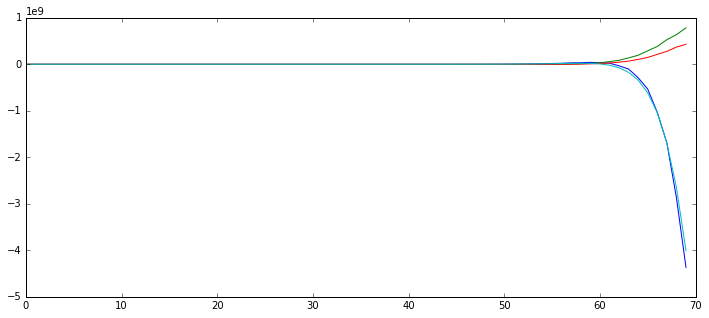

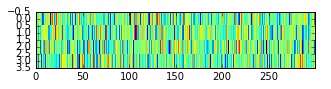

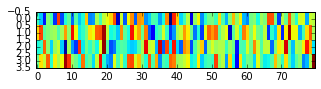

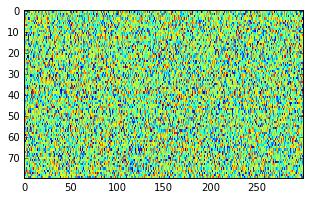

Training epoch took 11.384629 
Epoch 6 / 100 | train cost = 0.904808 | test cost = 0.890209 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.732338 
Epoch 7 / 100 | train cost = 0.887443 | test cost = 0.877901 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.610471 
Epoch 8 / 100 | train cost = 0.877686 | test cost = 0.870013 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.831239 
Epoch 9 / 100 | train cost = 0.870663 | test cost = 0.864684 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.558663 
Epoch 10 / 100 | train cost = 0.865892 | test cost = 0.857227 | lr = 0.000000 | momentum = 0.900000
Generating 200 frames: 


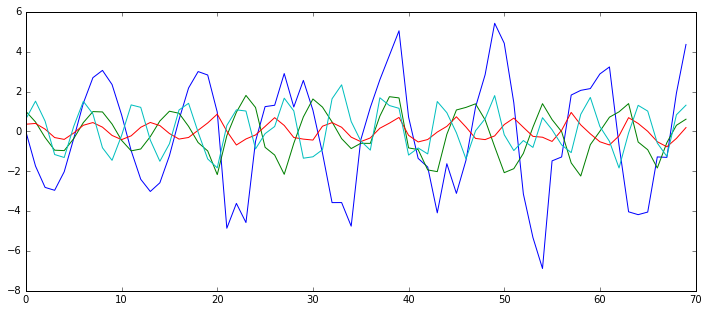

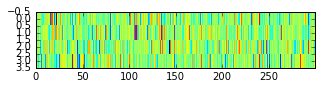

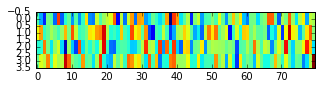

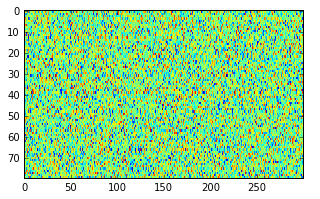

Training epoch took 11.518146 
Epoch 11 / 100 | train cost = 0.863353 | test cost = 0.859759 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.678409 
Epoch 12 / 100 | train cost = 0.860546 | test cost = 0.853145 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.659135 
Epoch 13 / 100 | train cost = 0.858487 | test cost = 0.851891 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.365185 
Epoch 14 / 100 | train cost = 0.857160 | test cost = 0.857696 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.580918 
Epoch 15 / 100 | train cost = 0.857155 | test cost = 0.857996 | lr = 0.000000 | momentum = 0.900000
Generating 200 frames: 


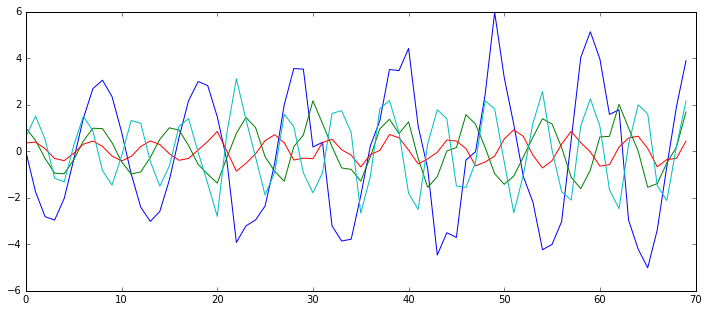

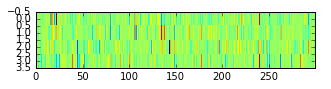

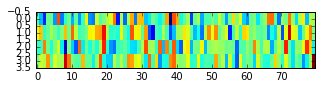

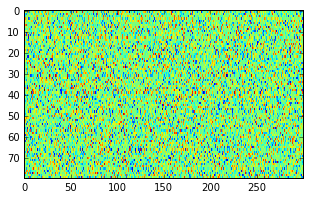

Training epoch took 11.700588 
Epoch 16 / 100 | train cost = 0.856744 | test cost = 0.852611 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.734018 
Epoch 17 / 100 | train cost = 0.856984 | test cost = 0.853098 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.671951 
Epoch 18 / 100 | train cost = 0.856839 | test cost = 0.854453 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.705812 
Epoch 19 / 100 | train cost = 0.857866 | test cost = 0.853160 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.388377 
Epoch 20 / 100 | train cost = 0.858853 | test cost = 0.851507 | lr = 0.000000 | momentum = 0.900000
Generating 200 frames: 


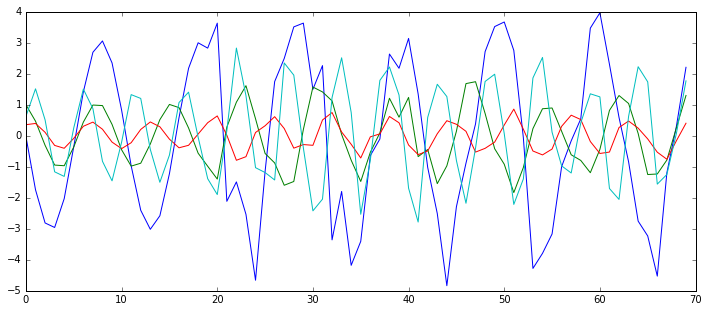

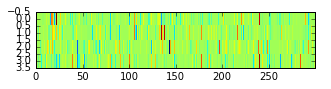

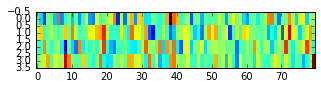

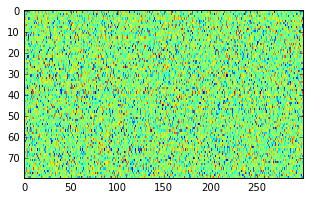

Training epoch took 11.324520 
Epoch 21 / 100 | train cost = 0.859409 | test cost = 0.854565 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.499875 
Epoch 22 / 100 | train cost = 0.861093 | test cost = 0.856129 | lr = 0.000000 | momentum = 0.900000
Training epoch took 11.485043 
Epoch 23 / 100 | train cost = 0.862625 | test cost = 0.860861 | lr = 0.000000 | momentum = 0.900000


KeyboardInterrupt: 

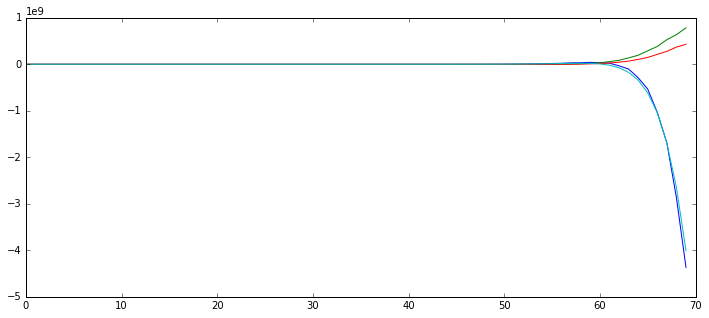

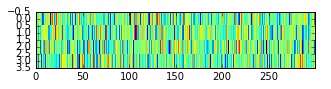

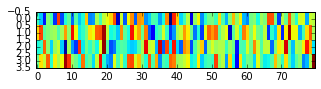

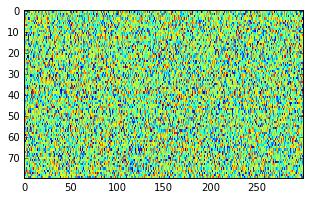

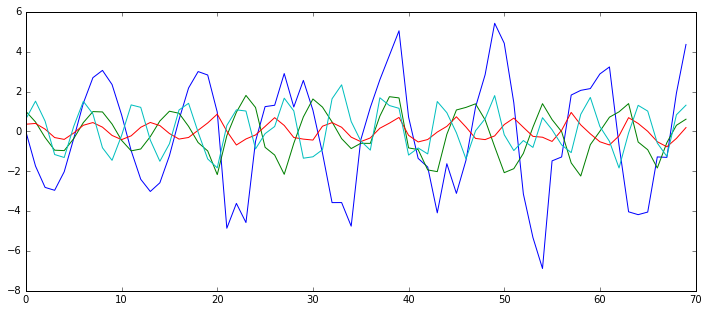

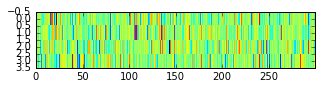

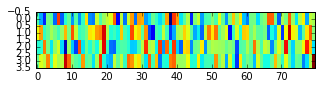

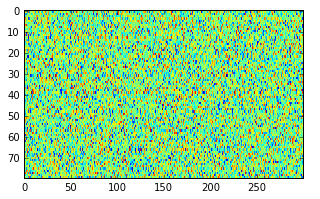

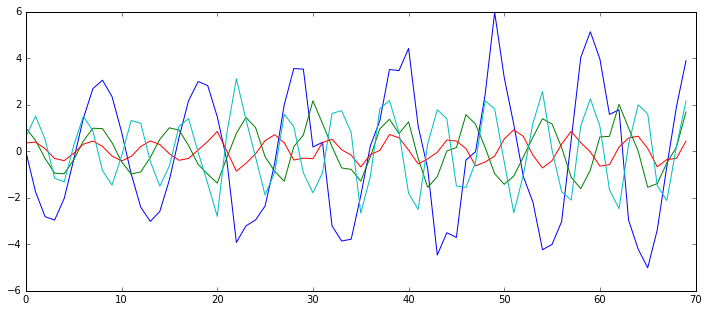

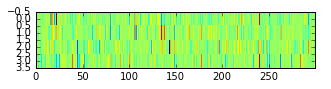

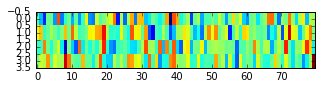

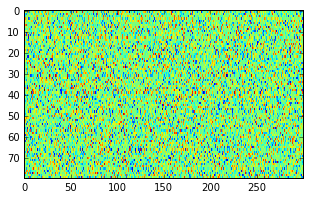

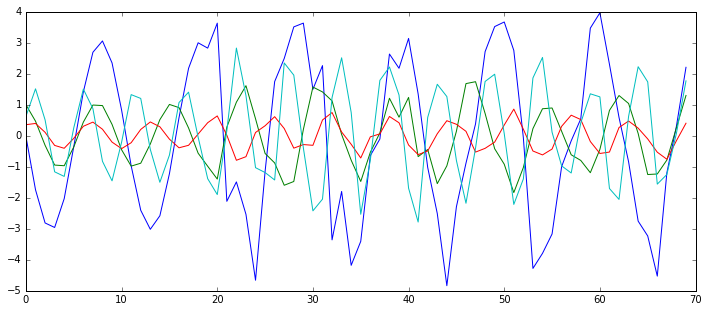

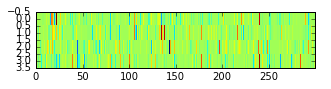

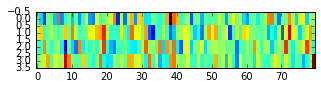

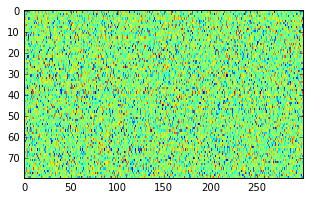

In [32]:
tf.reset_default_graph()
c1 = CRBM(num_vis=num_vis, num_cond=num_cond, num_hid=num_hid, 
          vis_type=vis_type, 
          name='crbm_toy', 
          activation=activation,
          initializer=initializer,
          W_regularizer=regularizer,
          A_regularizer=regularizer,
          B_regularizer=regularizer)


mom = tf.Variable(initial_value=0, dtype=tf.float32)
vis_data_ph = tf.placeholder(tf.float32, shape=(None, visible_data.shape[1]), name='batch_data')
cond_data_ph = tf.placeholder(tf.float32, shape=(None, cond_data.shape[1]), name='cond_data')
lr = tf.Variable(initial_value=0, dtype=tf.float32)

# initial_learning_rate = 0.01
# decay_steps = 100000
# decay_rate = 1/10
# global_step = tf.Variable(0, trainable=False, name="global_step")
# lr = tf.train.exponential_decay(initial_learning_rate, global_step,
#                                                 decay_steps, decay_rate)
    
    
# Initialize the tf variables
init = tf.global_variables_initializer()

# Lunch the session
sess = tf.Session()
sess.run(init)

## Train
print('-'*80)
print('Training %s CRBM with %i %s units'%(vis_type, num_hid, activation))
# print('sparsity target: %1.4f, sparsity cost: %1.3f, sparse_decay %1.3f'%(sparse_target, sparse_cost, sparse_decay))
print('-'*80)
# print('Dataset: %s'%(mocdataset))
print('Model order: %i'%(timesteps))
print('Training data size: %s sequences of length %i'%(len(visible_data), timesteps))
print('-'*80)

training_epochs = 100

# Make batches
batch_idxs = np.random.permutation(range(len(visible_data)))
n_batches = len(batch_idxs) // batch_size





# Define train ops            
train_op = c1.train_step(vis_data_ph,
                           cond_data_ph, 
                           lr, 
                           mom, 
                           wdecay, 
                           cd_k=cd_k)

reccost_op = c1.get_reconstruction_cost(vis_data_ph, cond_data_ph)


cost_summary = tf.summary.scalar('train_cost', reccost_op)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())


# options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
# run_metadata = tf.RunMetadata()
# tl = 0


# Run everything in tf 
for epoch in range(training_epochs):
    start_time = time.time()
    
    train_cost = 0
    
    if epoch < 5:
        learning_rate = 0.001
        momentum = 0
    else:
        momentum = 0.9
        learning_rate = 0.001
   
    
    for batch_i in range(n_batches):
#         sess.run(tf.assign_add(global_step, 1))

        # Get just minibatch amount of data
        idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]

        # Add noise to the past, Gaussian with std 1
        cd_noise = cond_data[idxs_i] + np.random.normal(0, 1, [batch_size, num_cond])

        # Create the feed for the batch data
        feed = feed_dict={vis_data_ph: visible_data[idxs_i],
                          cond_data_ph: cd_noise,
                          lr: learning_rate,
                          mom: momentum}

        # Run the training step
        sess.run(train_op, feed_dict=feed)#, options=options, run_metadata=run_metadata)

#         if tl == 0:
#             # Create the Timeline object, and write it to a json file
#             fetched_timeline = timeline.Timeline(run_metadata.step_stats)
#             chrome_trace = fetched_timeline.generate_chrome_trace_format()
#             with open('timeline_onestep.json', 'w') as f:
#                 f.write(chrome_trace)
#             tl = 1

        feed = feed_dict={vis_data_ph: visible_data[idxs_i],
                      cond_data_ph: cond_data[idxs_i]}

        train_cost = train_cost + sess.run(reccost_op, feed_dict=feed)
        
#         if batch_i % 10 == 0:
#             summary_str = cost_summary.eval(session=sess, feed_dict=feed)
#             step = epoch * n_batches + batch_i
#             file_writer.add_summary(summary_str, step)
        
    train_cost = train_cost/n_batches
    
    elapsed_time = time.time() - start_time
    
    print('Training epoch took %f '%elapsed_time)
    
    feed = feed_dict={vis_data_ph: test_data,
                          cond_data_ph: test_cond}
    
    test_cost = sess.run(reccost_op, feed_dict=feed)

    print('Epoch %i / %i | train cost = %f | test cost = %f | lr = %f | momentum = %f'%
         (epoch+1, training_epochs, train_cost, test_cost, lr.eval(session=sess), momentum))
    
        
    if (epoch+1) % 5 == 0:
        W, A, B, vb, hb = (c1.W.eval(session=sess), 
                           c1.A.eval(session=sess), 
                           c1.B.eval(session=sess), 
                           c1.vbias.eval(session=sess), 
                           c1.hbias.eval(session=sess))
        
        generate()

        
file_writer.close()